In [1]:
import yt
from yt.units import dimensions
import numpy as np
import unyt
import scipy.interpolate
import matplotlib.pyplot as plt

mH = 1.673533e-24
kB = 1.380649e-16 # Boltzmann constant (cgs)

def _abs_z(field, data):
    return np.abs(data["gas", "z"])

yt.add_field(
    name=("gas", "abs_z"),
    function=_abs_z,
    sampling_type="local",
    units="auto",
    dimensions=dimensions.length,
)

my_alpha = 0.1

def compute_entropy_profile(ds):
    source = ds.all_data()
    # compute entropy histogram
    K_bins = np.logspace(-4.2, -3.5, 20)
    z_bins = np.logspace(np.log10(10.), 2.0, 20) * 3.086e18 * 1.0e3
    histogram = yt.data_objects.profiles.create_profile(source,
        [("gas", "abs_z"), ("parthenon", "entropy")],
        [("gas", "cell_mass")]
        , override_bins={("parthenon", "entropy"): K_bins, ("gas", "abs_z"): z_bins})
    
    bins_x = np.log10(histogram.x / 3.086e18 / 1.0e3) # abs_z
    bins_y = np.log10(histogram.y) # entropy
    hist = histogram["gas", "cell_mass"] / 1.99e33  # profile field
    lb = np.zeros(len(bins_x))
    ub = np.zeros(len(bins_x))
    median = np.zeros(len(bins_x))
    for i in range(len(bins_x)):
        cdf = np.concatenate([np.array([0]), np.cumsum(hist[i,:])])
        cdf /= cdf[-1]
        interp = scipy.interpolate.interp1d(cdf, np.log10(K_bins), kind='linear')
        median[i] = interp(0.5)
        lb[i] = interp(0.16)
        ub[i] = interp(0.84)
    
    return float(ds.current_time), bins_x, median, lb, ub
        
def plot_entropy(datasets, filename_base):
    plt.clf()
    for ds, my_label in datasets:
        t, bins_x, median, lb, ub = compute_entropy_profile(ds)
        plt.plot(bins_x, median, label='median $\log K$ (' + my_label + ')')
        plt.fill_between(bins_x, lb, ub, alpha=my_alpha, label=r'1$\sigma$ region')
    plt.ylim(-4.2, -3.5)
    plt.xlim(1., 2.)
    plt.xlabel(r'$\log |z|$ (kpc)')
    plt.ylabel(r'$\log K$')
    plt.title(r'$t = ' + f'{t:.1f}' + r'$ Myr')
    plt.legend(loc='upper left')
    plt.savefig(filename_base + "_entropy.png", dpi=150)
    
    
def compute_density_profile(ds):
    source = ds.all_data()
    # compute density histogram
    ndens_bins = np.logspace(-3, -1.5, 20) * mH
    z_bins = np.logspace(np.log10(10.), 2.0, 20) * 3.086e18 * 1.0e3
    histogram = yt.data_objects.profiles.create_profile(source,
        [("gas", "abs_z"), ("gas", "density")], [("gas", "cell_mass")],
        override_bins={("gas", "density"): ndens_bins, ("gas", "abs_z"): z_bins})

    bins_x = np.log10(histogram.x / 3.086e18 / 1.0e3) # abs_z
    bins_y = np.log10(histogram.y / mH) # number density
    hist = histogram["gas", "cell_mass"] / 1.99e33  # profile field
    lb = np.zeros(len(bins_x))
    ub = np.zeros(len(bins_x))
    median = np.zeros(len(bins_x))
    for i in range(len(bins_x)):
        cdf = np.concatenate([np.array([0]), np.cumsum(hist[i,:])])
        cdf /= cdf[-1]
        interp = scipy.interpolate.interp1d(cdf, np.log10(ndens_bins / mH), kind='linear')
        median[i] = interp(0.5)
        lb[i] = interp(0.16)
        ub[i] = interp(0.84)
    
    return float(ds.current_time), bins_x, median, lb, ub
    
def plot_density(datasets, filename_base):
    plt.clf()
    #plt.imshow(hist.T, origin='lower', extent=[bins_x[0], bins_x[-1], bins_y[0], bins_y[-1]], aspect='auto')
    for ds, my_label in datasets:
        t, bins_x, median, lb, ub = compute_density_profile(ds)
        plt.plot(bins_x, median, label='median $\log K$ (' + my_label + ')')
        plt.fill_between(bins_x, lb, ub, alpha=my_alpha, label=r'1$\sigma$ region')
    plt.xlabel(r'$\log |z|$ (kpc)')
    plt.ylabel(r'$\log n_H$')
    plt.ylim(-3.0, -1.5)
    plt.xlim(1., 2.)
    plt.title(r'$t = ' + f'{float(ds.current_time):.1f}' + r'$ Myr')
    plt.legend(loc='upper right')
    plt.savefig(filename_base + "_density.png", dpi=150)
    
def compute_temperature_profile(ds):
    source = ds.all_data()
    # compute temperature histogram
    T_bins = np.logspace(7.0, 8.0, 20)
    z_bins = np.logspace(np.log10(10.), 2.0, 20) * 3.086e18 * 1.0e3
    histogram = yt.data_objects.profiles.create_profile(source,
        [("gas", "abs_z"), ("gas", "temperature")], [("gas", "cell_mass")],
        override_bins={("gas", "temperature"): T_bins, ("gas", "abs_z"): z_bins})
    bins_x = np.log10(histogram.x / 3.086e18 / 1.0e3) # abs_z
    bins_y = np.log10(histogram.y) # temperature
    hist = histogram["gas", "cell_mass"] / 1.99e33  # profile field

    lb = np.zeros(len(bins_x))
    ub = np.zeros(len(bins_x))
    median = np.zeros(len(bins_x))
    for i in range(len(bins_x)):
        cdf = np.concatenate([np.array([0]), np.cumsum(hist[i,:])])
        cdf /= cdf[-1]
        interp = scipy.interpolate.interp1d(cdf, np.log10(T_bins), kind='linear')
        median[i] = interp(0.5)
        lb[i] = interp(0.16)
        ub[i] = interp(0.84)
    
    return float(ds.current_time), bins_x, median, lb, ub
    
def plot_temperature(datasets, filename_base):
    plt.clf()
    #plt.imshow(hist.T, origin='lower', extent=[bins_x[0], bins_x[-1], bins_y[0], bins_y[-1]], aspect='auto')
    for ds, my_label in datasets:
        t, bins_x, median, lb, ub = compute_temperature_profile(ds)
        plt.plot(bins_x, median, label='median $\log K$ (' + my_label + ')')
        plt.fill_between(bins_x, lb, ub, alpha=my_alpha, label=r'1$\sigma$ region')
    plt.xlabel(r'$\log |z|$ (kpc)')
    plt.ylabel(r'$\log T$ (K)')
    plt.ylim(7.0, 8.0)
    plt.xlim(1., 2.)
    plt.title(r'$t = ' + f'{float(ds.current_time):.1f}' + r'$ Myr')
    plt.legend(loc='upper right')
    plt.savefig(filename_base + "_temp.png", dpi=150)

def compute_pressure_profile(ds):
    source = ds.all_data()
    # compute pressure profile histogram
    P_bins = np.logspace(5, 6, 20) * kB
    z_bins = np.logspace(np.log10(10.), 2.0, 20) * 3.086e18 * 1.0e3
    histogram = yt.data_objects.profiles.create_profile(source,
        [("gas", "abs_z"), ("gas", "pressure")], [("gas", "cell_mass")],
        override_bins={("gas", "pressure"): P_bins, ("gas", "abs_z"): z_bins})

    bins_x = np.log10(histogram.x / 3.086e18 / 1.0e3) # abs_z
    bins_y = np.log10(histogram.y / kB) # number density
    hist = histogram["gas", "cell_mass"] / 1.99e33  # profile field
    lb = np.zeros(len(bins_x))
    ub = np.zeros(len(bins_x))
    median = np.zeros(len(bins_x))
    for i in range(len(bins_x)):
        cdf = np.concatenate([np.array([0]), np.cumsum(hist[i,:])])
        cdf /= cdf[-1]
        interp = scipy.interpolate.interp1d(cdf, np.log10(P_bins / kB), kind='linear')
        median[i] = interp(0.5)
        lb[i] = interp(0.16)
        ub[i] = interp(0.84)
        
    return float(ds.current_time), bins_x, median, lb, ub
    
def plot_pressure(datasets, filename_base):
    plt.clf()
    #plt.imshow(hist.T, origin='lower', extent=[bins_x[0], bins_x[-1], bins_y[0], bins_y[-1]], aspect='auto')
    for ds, my_label in datasets:
        t, bins_x, median, lb, ub = compute_pressure_profile(ds)
        plt.plot(bins_x, median, label='median $\log K$ (' + my_label + ')')
        plt.fill_between(bins_x, lb, ub, alpha=my_alpha, label=r'1$\sigma$ region')
    plt.xlabel(r'$\log |z|$ (kpc)')
    plt.ylabel(r'$\log P$ (K cm$^{-3}$)')
    plt.ylim(5., 6.)
    plt.xlim(1., 2.)
    plt.title(r'$t = ' + f'{float(ds.current_time):.1f}' + r'$ Myr')
    plt.legend(loc='upper right')
    plt.savefig(filename_base + "_pressure.png", dpi=150)


yt : [INFO     ] 2023-11-16 17:36:30,435 Parameters: current_time              = 0.0
yt : [INFO     ] 2023-11-16 17:36:30,435 Parameters: domain_dimensions         = [ 64  64 128]
yt : [INFO     ] 2023-11-16 17:36:30,436 Parameters: domain_left_edge          = [ -50.  -50. -100.]
yt : [INFO     ] 2023-11-16 17:36:30,436 Parameters: domain_right_edge         = [ 50.  50. 100.]
yt : [INFO     ] 2023-11-16 17:36:30,436 Parameters: cosmological_simulation   = False


yt : [INFO     ] 2023-11-16 17:36:31,368 Parameters: current_time              = 500.1622357044253
yt : [INFO     ] 2023-11-16 17:36:31,369 Parameters: domain_dimensions         = [ 64  64 128]
yt : [INFO     ] 2023-11-16 17:36:31,369 Parameters: domain_left_edge          = [ -50.  -50. -100.]
yt : [INFO     ] 2023-11-16 17:36:31,369 Parameters: domain_right_edge         = [ 50.  50. 100.]
yt : [INFO     ] 2023-11-16 17:36:31,370 Parameters: cosmological_simulation   = False
yt : [INFO     ] 2023-11-16 17:36:32,675 Parameters: current_time              = 1000.1791531186522
yt : [INFO     ] 2023-11-16 17:36:32,675 Parameters: domain_dimensions         = [ 64  64 128]
yt : [INFO     ] 2023-11-16 17:36:32,675 Parameters: domain_left_edge          = [ -50.  -50. -100.]
yt : [INFO     ] 2023-11-16 17:36:32,676 Parameters: domain_right_edge         = [ 50.  50. 100.]
yt : [INFO     ] 2023-11-16 17:36:32,676 Parameters: cosmological_simulation   = False
yt : [INFO     ] 2023-11-16 17:36:34,09

FileNotFoundError: No such file or directory: './parthenon.prim.00006.phdf'.

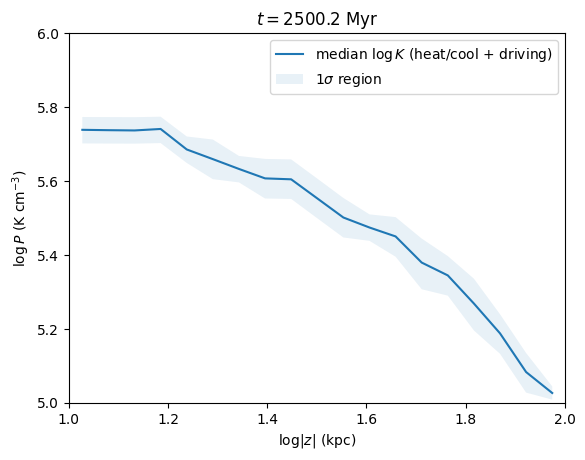

In [5]:
root_dir1 = "./"
filenames = [(root_dir1 + "parthenon.prim." + str(i).zfill(5) + ".phdf", root_dir1 + "output" + str(i).zfill(5)) for i in range(40)]

for fname1, output_base in filenames:
    ds1 = yt.load(fname1)
    datasets = [(ds1, 'heat/cool + driving')]
    plot_entropy(datasets, output_base)
    plot_density(datasets, output_base)
    plot_temperature(datasets, output_base)
    plot_pressure(datasets, output_base)
    ds1.close()
